In [1]:
def plot_with_corners(image, corners_matrix, inline: bool=True):
    
    import matplotlib.pyplot as plt
    
    if inline:
        # show inline image for the reader
        %matplotlib inline
    else:
        # show in external window to manually read the coordinates
        %matplotlib qt 
        
    plt.figure(figsize=(20,10))
    plt.imshow(image)
    plt.plot(corners_matrix[0][0], corners_matrix[0][1], "Xr") # top-left red star
    plt.plot(corners_matrix[1][0], corners_matrix[1][1], "Xb") # top-right red star
    plt.plot(corners_matrix[2][0], corners_matrix[2][1], "Xg") # bottom-right red star
    plt.plot(corners_matrix[3][0], corners_matrix[3][1], "Xy") # bottom-left red star

# Project 4: Andvanced Road Lane Lines

by Uki D. Lucas

This project is written to meet following requirements:
https://review.udacity.com/#!/rubrics/571/view

## Project Objectives

The goals / steps of this project are the following:

- 1) Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
- 2) Apply a distortion correction to raw images.
- Use color transforms, gradients, etc., to create a thresholded binary image.
- Apply a perspective transform to rectify binary image ("birds-eye view").
- Detect lane pixels and fit to find the lane boundary.
- Determine the curvature of the lane and vehicle position with respect to center.
- Warp the detected lane boundaries back onto the original image.
- Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

The images for camera calibration are stored in the folder called **camera_cal**.  

The images in **test_images** are for testing your pipeline on single frames.  

If you want to extract more test images from the videos, you can simply use an image writing method like cv2.imwrite(), i.e., you can read the video in frame by frame as usual, and for frames you want to save for later you can write to an image file.  

To help the reviewer examine your work, please save examples of the output from each stage of your pipeline in the folder called ouput_images, and include a description in your writeup for the project of what each image shows.    

The video called **project_video.mp4** is the video your pipeline should work well on.  

The **challenge_video.mp4** video is an extra (and optional) challenge for you if you want to test your pipeline under somewhat trickier conditions.  

**The harder_challenge.mp4 video is another optional challenge and is brutal!**

If you're feeling ambitious (again, totally optional though), don't stop there!  

We encourage you to go out and take video of your own, calibrate your camera and show us how you would implement this project from scratch!

---

# Camera distortion calibration

## 1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images

#### OpenCV functions or other methods were used to calculate the correct camera matrix and distortion coefficients using the calibration chessboard images provided in the repository (note these are 9x6 chessboard images, unlike the 8x6 images used in the lesson). The distortion matrix should be used to un-distort one of the calibration images provided as a demonstration that the calibration is correct. Example of undistorted calibration image is Included in the writeup (or saved to a folder).

The very well documented code for this step is contained in document **camera_calibration**  available in HTML, ipynb and py formats. 

### The expected RESULT of calibration (**red lines were applied manually**):

This image was generated by Uki D. Lucas

<img src="example_calibration.png" />

# Define Useful Functions

In [2]:
def __get_sample_gray(image_file_name: str):
    import cv2 # we will use OpenCV library
    image_original = cv2.imread(image_file_name)
    # convert BGR image to gray-scale
    image_gray = cv2.cvtColor(image_original, cv2.COLOR_BGR2GRAY)
    return image_original, image_gray

In [3]:
def plot_images(left_image, right_image):
    import numpy as np
    import matplotlib.pyplot as plt
    plt.figure(figsize=(20,10))
    plot_image = np.concatenate((left_image, right_image), axis=1)
    plt.imshow(plot_image)
    plt.show() 

In [4]:
def prep_calibration(image_file_names: list, use_optimized = True, verbose = False):
    
    # we will use OpenCV library
    import cv2 
    
    # find CORNERS
    object_point_list, image_points_list = __find_inside_corners(image_file_names)
    
    # get sample image, mostly for dimensions
    image_original, image_gray = __get_sample_gray(image_file_names[1])

    # Learn calibration
    # Returns:
    # - camera matrix
    # - distortion coefficients
    # - rotation vectors
    # - translation vectors
    has_sucess, matrix, distortion, rvecs, tvecs = cv2.calibrateCamera(
        object_point_list, 
        image_points_list, 
        image_gray.shape[::-1], 
        None, 
        None)
    
    ## I can use this to improve the calibration (no cropped edges, but curved edges)
    image_dimentions = image_original.shape[:2] # height, width
    matrix_optimized, roi = cv2.getOptimalNewCameraMatrix(
        matrix, 
        distortion, 
        image_dimentions, 
        1, 
        image_dimentions)
    return matrix, matrix_optimized, distortion

## 1.1. Read 20 sample chessboard images taken with the camera we want to callibrate

In [5]:
import glob
image_file_names = glob.glob("camera_cal/calibration*.jpg")
print(len(image_file_names), "images found")

20 images found


In [6]:
def __find_inside_corners(image_file_names: list, nx: int=9, ny: int=6, verbose = False):
    """
    Chessboard dimentsions:
     nx = 9 # horizontal
     ny = 6 # vertical
    """
    import cv2 # we will use OpenCV library
    import numpy as np
    # Initialise arrays

    # Object Points: points on the original picture of chessboard
    object_point_list = []

    #Image Points: points on the perfect 2D chessboard
    image_points_list = []

    # Generate 3D object points
    object_points = np.zeros((nx*ny, 3), np.float32)
    object_points[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

    #print("first 5 elements:\n", object_points[0:5])
    # see: http://docs.opencv.org/trunk/dc/dbb/tutorial_py_calibration.html

    termination_criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    chessboard_dimentions = (nx, ny)
    import matplotlib.pyplot as plt
    for image_file_name in image_file_names:
        
        if verbose:
            print("processing image:", image_file_name)
        image_original, image_gray = __get_sample_gray(image_file_name)

        # Find the chess board corners
        # Paramters:
        # - image_gray
        # - the chessboard to be used is 9x6
        # - flags = None
        has_found, corners = cv2.findChessboardCorners(image_gray, chessboard_dimentions, None)
        
        if has_found == True:
            # fill in ObjectPoints
            object_point_list.append(object_points)

            corners2 = cv2.cornerSubPix(image_gray, corners, (11,11), (-1,-1), termination_criteria)
            # fill in ImagePoints
            image_points_list.append(corners2)

            # Draw and display the corners
            # I have to clone/copy the image because cv2.drawChessboardCorners changes the content
            image_corners = cv2.drawChessboardCorners(
                image_original.copy(), 
                chessboard_dimentions, 
                corners2, 
                has_found)

            if verbose:
                plot_images(image_original, image_corners)
        else: # not has_found
            if verbose:
                print("The", chessboard_dimentions, 
                  "chessboard pattern was not found, most likely partial chessboard showing")
                plt.figure()
                plt.imshow(image_original)
                plt.show()
        # end if has_found
    # end for
    return object_point_list, image_points_list

## 1.2. Learn calibration based on sample images

In [7]:
#import camera_calibration as cam # local camera_calibration.py, same directory

camera_matrix, matrix_optimized, distortion_coefficients = prep_calibration(
    image_file_names, 
    use_optimized = True)

# 2. Apply a distortion correction to raw images


## 2.1. Processing pipeline (single image shown)

I have chosen an interesting chessboard image that will show a very dramatic transformation.

In [8]:
#image_file_path = "test_images/test1.jpg"
#image_file_path = "test_images/stop_sign_angle_001.png"
image_file_path = "camera_cal/calibration8.jpg"
import os
import matplotlib.image as mpimg

if os.path.isfile(image_file_path): 
    image = mpimg.imread(image_file_path)
    
import matplotlib.pyplot as plt

# show in external window to manually read the coordinates
#%matplotlib qt 
# show inline image for the reader
#%matplotlib inline
#plt.imshow(image)

## 2.2. Correcting the "fish-eye" effect caused by the shape of the camera lense 

### 2.2.1. Not optimzed matrix (cutting off curving margins, loosing data)

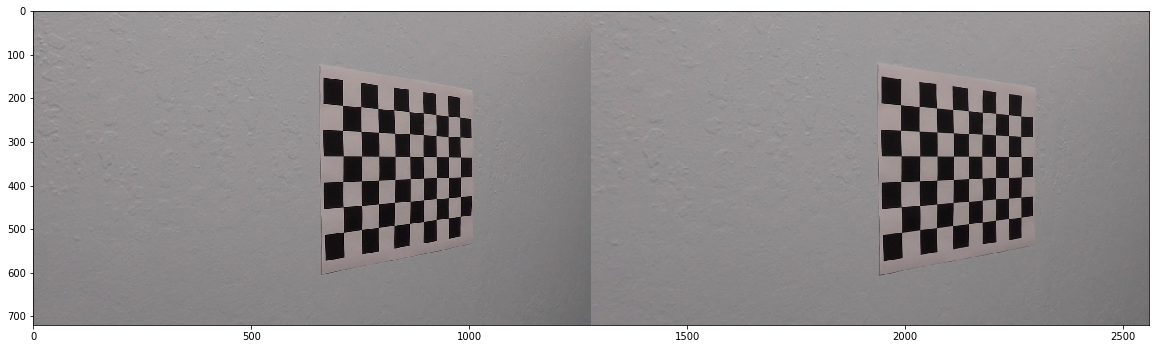

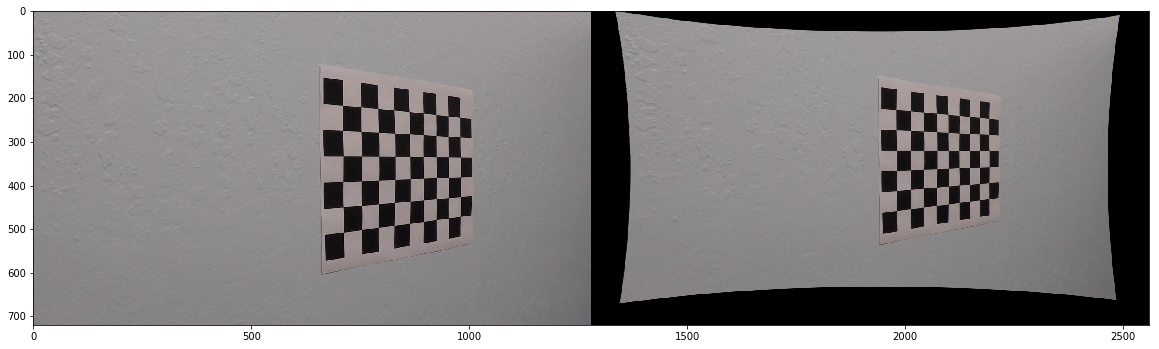

In [9]:
import cv2 # we will use OpenCV library
image = cv2.imread(image_file_path)
image_corrected1 = cv2.undistort(image, camera_matrix, distortion_coefficients, None, None)
plot_images(image, image_corrected1)
image_corrected2 = cv2.undistort(image, camera_matrix, distortion_coefficients, None, matrix_optimized)
plot_images(image, image_corrected2)

## 2.3. Continue with the corrected image

<hr />

### 2. Color transforms, gradients or other methods to create a thresholded binary image.

#### A method or combination of methods (i.e., color transforms, gradients) has been used to create a binary image containing likely lane pixels. There is no "ground truth" here, just visual verification that the pixels identified as part of the lane lines are, in fact, part of the lines. Example binary images should be included in the writeup (or saved to a folder) and submitted with the project.

I used a combination of color and gradient thresholds to generate a binary image (thresholding steps at lines # through # in another_file.py).  Here's an example of my output for this step.  (note: this is not actually from one of the test images)

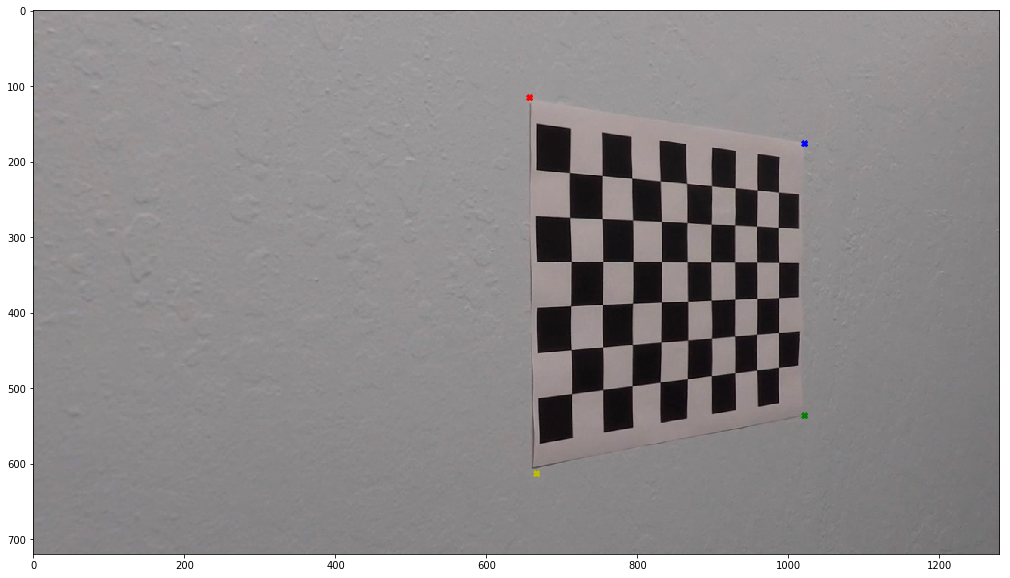

In [10]:
# show in external window to manually read the coordinates
#%matplotlib qt 
# show inline image for the reader
%matplotlib inline
#plt.imshow(image)plot_images(image, warped)

import numpy as np
# calibration8 source
SRC = np.float32([
    [657,115],
    [1021,175],
    [1021,536],
    [665,613]])

plot_with_corners(image_corrected1, SRC, inline=True)

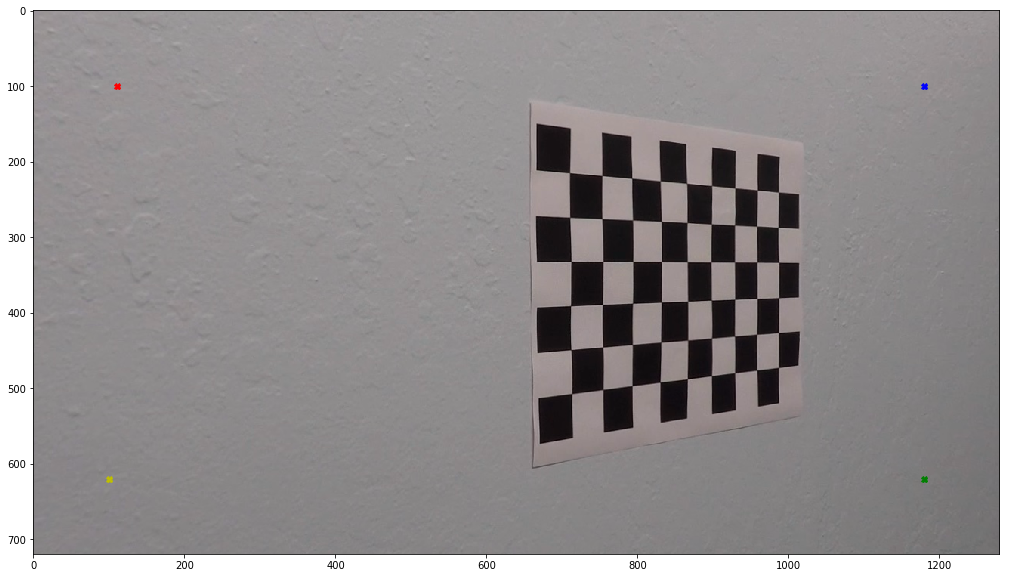

In [11]:
import numpy as np
# calibration8 destination
DEST = np.float32([
    [110,100],
    [1180,100],
    [1180,620],
    [100,620]])
plot_with_corners(image_corrected1, DEST, inline=True)

[[  1.36497104e+00  -3.94521318e-02  -8.18984419e+02]
 [ -1.61619982e-01   6.72327830e-01   9.54707753e+01]
 [ -5.02456036e-04  -3.34340100e-05   1.00000000e+00]]


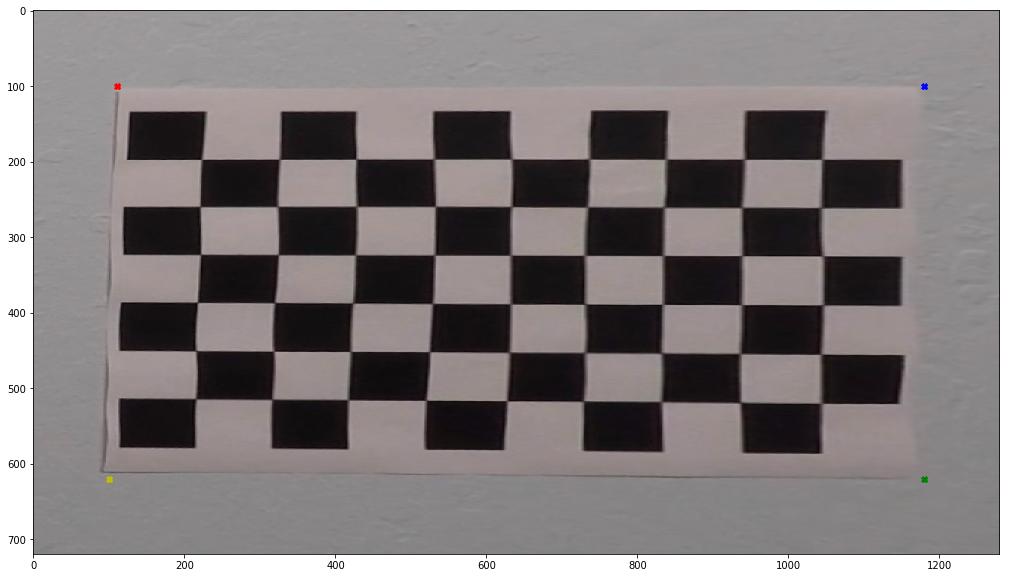

In [12]:
# http://docs.opencv.org/3.1.0/da/d6e/tutorial_py_geometric_transformations.html
M = cv2.getPerspectiveTransform(SRC, DEST)
print(M)
img_size = (image_corrected1.shape[1], image_corrected1.shape[0])
image_warped = cv2.warpPerspective(image_corrected1, M, img_size)
plot_with_corners(image_warped, DEST, inline=True)

# Switch to real road picture

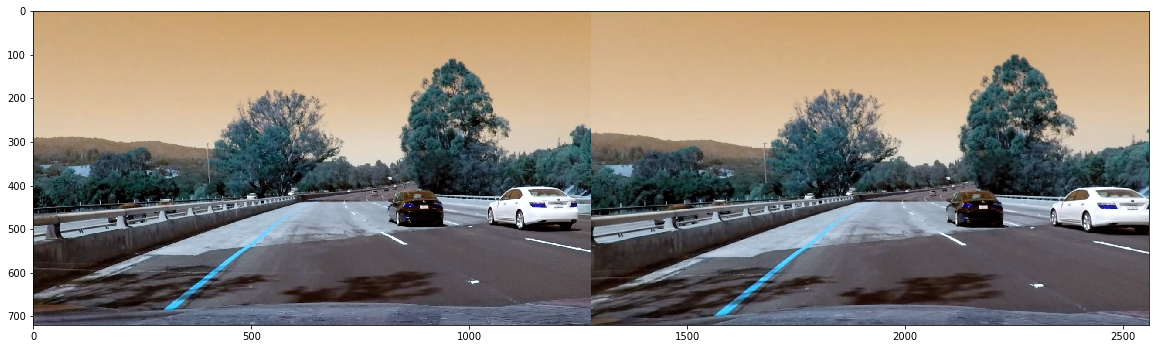

In [13]:
image_file_path = "test_images/test4.jpg"

import cv2 # we will use OpenCV library
image = cv2.imread(image_file_path)
image_corrected = cv2.undistort(image, camera_matrix, distortion_coefficients, None, None)
plot_images(image, image_corrected)

[[  585.   450.]
 [  200.   675.]
 [ 1080.   675.]
 [  695.   450.]]
[[ 320.    0.]
 [ 320.  720.]
 [ 960.  720.]
 [ 960.    0.]]


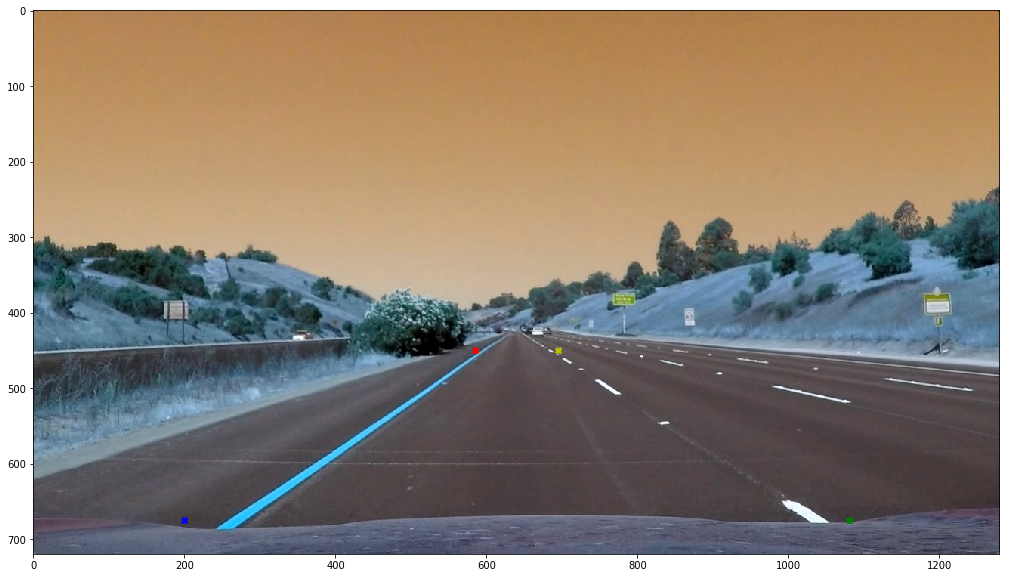

In [14]:
image_file_path = "test_images/straight_lines1.jpg"
import cv2 # we will use OpenCV library
image = cv2.imread(image_file_path)
import numpy as np

img_size = (image.shape[1], image.shape[0])
width = image.shape[1]
height = image.shape[0]

horizon_offset = 90
top_horizontal_offset = 55
car_hood_offset = 45
hood_to_width_offset = 200

SRC = np.float32(
        [[(width / 2) - top_horizontal_offset, height / 2 + horizon_offset], #619, 432
        [hood_to_width_offset, height - car_hood_offset],
        [width - hood_to_width_offset, height - car_hood_offset],
        [(width / 2 + top_horizontal_offset), height / 2 + horizon_offset]])

print(SRC)

DEST = np.float32(
        [[(width / 4), 0],
        [(width / 4), img_size[1]],
        [(width * 3 / 4), img_size[1]],
        [(width * 3 / 4), 0]])

print(DEST)

plot_with_corners(image, SRC, inline=True)

# Reference image with straight lines

I am using the reference image with staight lines to determine this camera's horizon (areas to mask)

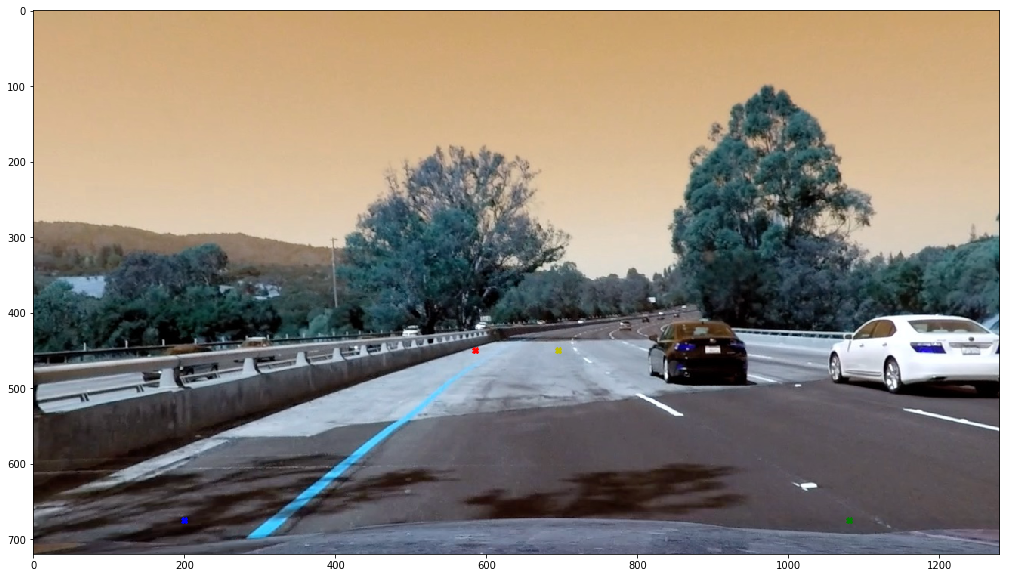

In [15]:
plot_with_corners(image_corrected, SRC, inline=True)

[[ -4.47552448e-01  -1.53162393e+00   9.26433566e+02]
 [ -6.32827124e-15  -1.96923077e+00   8.86153846e+02]
 [ -8.23993651e-18  -2.39316239e-03   1.00000000e+00]]


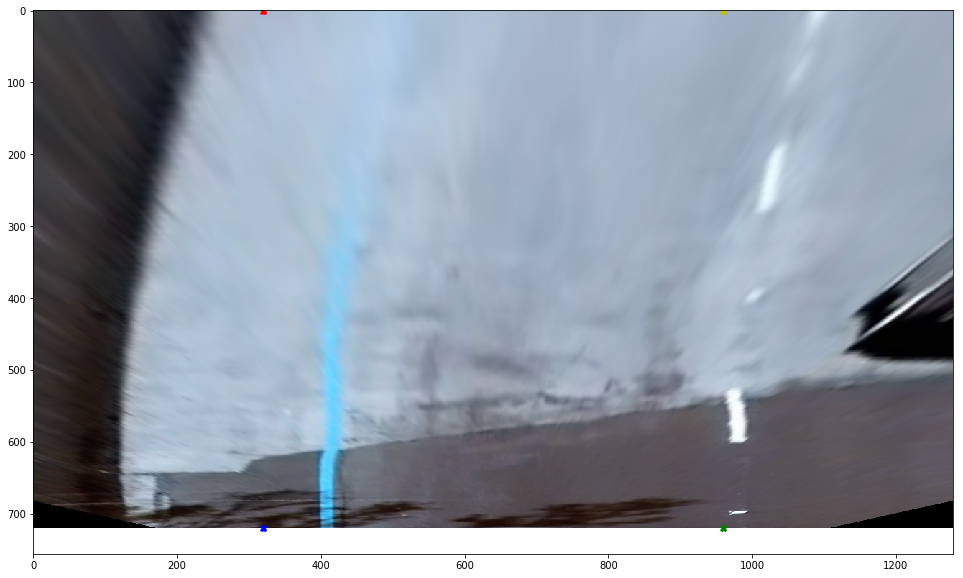

In [16]:
# http://docs.opencv.org/3.1.0/da/d6e/tutorial_py_geometric_transformations.html
M = cv2.getPerspectiveTransform(SRC, DEST)
print(M)
image_warped = cv2.warpPerspective(image_corrected, M, img_size)
#image_warped.reshape(image_warped.shape[0], image_warped.shape[1])
plot_with_corners(image_warped, DEST, inline=True)

In [17]:
def mask_lane_lines(img):
    '''
    Method masks lane lines.
    '''
    img = np.copy(img)

    #Blur
    kernel = np.ones((5,5),np.float32)/25
    img = cv2.filter2D(img,-1,kernel)

    #YUV for histogram equalization
    yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    yuv[:,:,0] = cv2.equalizeHist(yuv[:,:,0])
    img_wht = cv2.cvtColor(yuv, cv2.COLOR_YUV2BGR)

    #Compute white mask
    img_wht=img_wht[:,:,1]
    img_wht[img_wht<250]=0
    mask_wht = cv2.inRange(img_wht, 250, 255)

    yuv[:,:,0:1]=0

    #Yellow mask
    kernel = np.ones((5,5),np.float32)/25
    dst = cv2.filter2D(yuv,-1,kernel)
    sobelx = np.absolute(cv2.Sobel(yuv[:,:,2], cv2.CV_64F, 1, 0,ksize=5))
    sobelx[sobelx<200]=0
    sobelx[sobelx>=200]=255

    #Merge mask results
    mask = mask_wht + sobelx
    return mask


mask = mask_lane_lines(img = image_warped)

print(mask)

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


### Lane Masking

After the lens distortion has been removed, a binary image will be created, containing pixels which are likely part of a
lane. Therefore the result of multiple techniques are combined by a bitwise and operator. Finding good parameters for the different techniques like threshold values is quite challenging. To improve the feedback cycle of applying different parameters, an interactive [jupyter notebook](Interactive Parameter Exploration.ipynb) was created.
<br><br>
The first technique is called sobel operation which is able to detect edges by computing an approximation of the 
gradient of the image intensity function. The operation was applied for both directions (x and y) and combined to keep only
those pixel which are on both results and also over a specified threshold. An averaged gray scale image from
the U and V color channels of the YUV space and also the S channel of the HLS space was used as input. 
<br><br>
Additionally, the magnitude and direction of the gradient was calculated and combined by keeping only pixels with values above a threshold (different threshold for magnitude and direction) on both images.
<br><br>
Technique number three is a basic color thresholding which tries to isolate yellow pixels.
<br><br>
The last technique is an adaptive highlight / high intensity detection. It isolates all the pixels which have values above
a given percentile in order to make it more resilient against different lighting conditions.
<br><br>
In the end, the results are combined through a bitwise or operation to get the final lane mask.


Sobel X & Y                   |  Magnitude & Direction of Gradient  | Yellow | Highlights | Combined
:----------------------------:|:-----------------------------------:|:------:|:----------:|:---------:
![Sobel](output_images/test1_mask_sobelxy.jpg)| ![Gradient](output_images/test1_mask_gradient_mag_dir.jpg) | ![Yellow](output_images/test1_mask_ylw.jpg) | ![Highlights](output_images/test1_mask_highlights.jpg) | ![Combined](output_images/test1_mask.jpg)



# Birdseye View
To determine suitable source coordinates for the perspective transformation, an image with relative straight lines was
used as reference. Since the car was not perfectly centered the image, it was horizontally mirrored. The resulting image
was then used inside the interactive [jupyter notebook](Interactive Parameter Exploration.ipynb) to fit vanishing lines and to get source coordinates.

After suitable coordinates were determined, the transformation can be applied to other images. This is of course just an
approximation and is not 100% accurate. 

Mask                          |  Birdseye View
:----------------------------:|:-----------------------------------------------------------:
![Mask](output_images/test1_mask.jpg)| ![Birdseye](output_images/test1_birdseye.jpg)



# Identify Pixels

Since not all pixels marked in the mask are actually part of the lanes, the most likely ones have to be identified. For that, a sliding histogram is applied to detect clusters of marked pixels. The highest peak of each histogram is used as the center of a window which assigns each pixel inside to the corresponding lane. The sliding histogram is applied to the left half of the image to detect left line pixels and applied on the right half of the image to detect right lane pixels. Therefore, the algorithm will fail if a lane crosses the center of the image.
<br><br>
This process is pretty computing intensive. That's why the algorithm will try to find lane pixels in the area of
previously found lines first. This is only possible when using videos.

Left Lane Histogram             | Assigned Pixels                | Right Lane Histogram           
:------------------------------:|:------------------------------:|:------------------------------:
![Left Lane Histogram](output_images/test1_histogram_left.jpg) | ![Assigned Pixels](output_images/test1_pixel.jpg)| ![Right Lane Histogram](output_images/test1_histogram_right.jpg) 



### 4. Identified lane-line pixels and fit their positions with a polynomial

#### Methods have been used to identify lane line pixels in the rectified binary image. The left and right line have been identified and fit with a curved functional form (e.g., spine or polynomial). Example images with line pixels identified and a fit overplotted should be included in the writeup (or saved to a folder) and submitted with the project.

Then I did some other stuff and fit my lane lines with a 2nd order polynomial kinda like this:


 
Fit Visual
<img src="examples/color_fit_lines.jpg" alt="Fit Visual" />

### 5. Calculate the radius of curvature of the lane and the position of the vehicle with respect to center.

#### Here the idea is to take the measurements of where the lane lines are and estimate how much the road is curving and where the vehicle is located with respect to the center of the lane. The radius of curvature may be given in meters assuming the curve of the road follows a circle. For the position of the vehicle, you may assume the camera is mounted at the center of the car and the deviation of the midpoint of the lane from the center of the image is the offset you're looking for. As with the polynomial fitting, convert from pixels to meters.

I did this in lines # through # in my code in my_other_file.py

### 6. Image of the result plotted back down onto the road such that the lane area is identified clearly.

#### The fit from the rectified image has been warped back onto the original image and plotted to identify the lane boundaries. This should demonstrate that the lane boundaries were correctly identified. An example image with lanes, curvature, and position from center should be included in the writeup (or saved to a folder) and submitted with the project.

I implemented this step in lines # through # in my code in yet_another_file.py in the function map_lane().  Here is an example of my result on a test image:



Binary Example
<img src="examples/binary_combo_example.jpg" alt="Binary Example" />
 
Warp Example
<img src="examples/warped_straight_lines.jpg" alt="Warp Example" />

# Fit Polynomial

With pixels assigned to each lane, a second order polynomials can be fitted. To achieve smoother results, the polynomials 
are also average over the last five frames in a video. The polynomials are also used to calculate the curvature of the lane
and the relative offset from the car to the center line.

Fit Polynomial                | Final
:----------------------------:|:-----------------------------------------------------------:
![Mask](output_images/test1_lines.jpg)| ![Birdseye](output_images/test1_final.jpg)

# Pipeline (video)

### 1. Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (wobbly lines are ok but no catastrophic failures that would cause the car to drive off the road!).

#### The image processing pipeline that was established to find the lane lines in images successfully processes the video. The output here should be a new video where the lanes are identified in every frame, and outputs are generated regarding the radius of curvature of the lane and vehicle position within the lane. The pipeline should correctly map out curved lines and not fail when shadows or pavement color changes are present. The output video should be linked to in the writeup and/or saved and submitted with the project.

Here's a link to my video result


Output
<img src="examples/example_output.jpg" alt="Output" />

Video 

<video width="320" height="240" controls>
  <source src="project_video.mp4" type="video/mp4">
  Your browser does not support the video tag.
</video>

# Discussion

### 1. Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?

#### Discussion includes some consideration of problems/issues faced, what could be improved about their algorithm/pipeline, and what hypothetical cases would cause their pipeline to fail.

Here I'll talk about the approach I took, what techniques I used, what worked and why, where the pipeline might fail and how I might improve it if I were going to pursue this project further.  

In [18]:
# see http://nbconvert.readthedocs.io/en/latest/usage.html
!jupyter nbconvert --to markdown README.ipynb

[NbConvertApp] Converting notebook README.ipynb to markdown
[NbConvertApp] Support files will be in README_files/
[NbConvertApp] Making directory README_files
[NbConvertApp] Making directory README_files
[NbConvertApp] Making directory README_files
[NbConvertApp] Making directory README_files
[NbConvertApp] Making directory README_files
[NbConvertApp] Making directory README_files
[NbConvertApp] Writing 23092 bytes to README.md
